<a href="https://colab.research.google.com/github/PinkHedgehog/Semantic-segmentation-of-small-objects/blob/master/Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
def void(x):
    eval('x')
    return

Установить зависимости и подгрузить необходимые файлы

In [1]:
!apt-get install libopenslide-dev
!pip3 install openslide-python
!wget -O helpers.py https://raw.githubusercontent.com/PinkHedgehog/Semantic-segmentation-of-small-objects/master/helpers.py
!wget -O whole_slide.py https://raw.githubusercontent.com/PinkHedgehog/Semantic-segmentation-of-small-objects/master/whole_slide.py
!wget -O piece_of_slide.py https://raw.githubusercontent.com/PinkHedgehog/Semantic-segmentation-of-small-objects/master/piece_of_slide.py
#!wget -O best_model.pth 'https://drive.google.com/uc?export=download&id=1C_ygM4JjMNP3Mbwn0G2c2BjizU_C6jxv'
!pip3 install segmentation-models-pytorch
!pip3 install -U git+https://github.com/albumentations-team/albumentations

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
The following NEW packages will be installed:
  libopenslide-dev libopenslide0
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 101 kB of archives.
After this operation, 267 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide-dev amd64 3.4.1+dfsg-2 [21.7 kB]
Fetched 101 kB in 2s (66.0 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package libopenslide-dev.
Preparing to unpack .../libopenslide-dev_3.4.1+dfsg-2_

Импортировать необходимые модули и настроить параметры видеокарты

In [2]:


%reload_ext autoreload
%autoreload 2

import numpy as np
import os
import PIL
from PIL import Image, ImageColor, ImageEnhance, ImageFilter
import openslide
import cv2
import random
import matplotlib.pyplot as plt
import torch
import helpers as h
import piece_of_slide as POS
import whole_slide as WS
from torchsummary import summary

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, for our server either "0" , "1", "2" or "3";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

Загрузка слайдов

В силу слишком большого размера файлов автоматическая загрузка с Google-диска невозможна. Необходимо вручную скачать слайды по приложенным ссылкам, затем загрузить в сессию Colab:

[1 pr.svs](https://drive.google.com/uc?export=download&id=1klqBSB7Vg6U0TLLLF9V85_teKELn4BGH) (205 MB)

[1000577.svs](https://drive.google.com/uc?export=download&id=1GQg_QUY-rc8rlvgmE-nR99jBCTTw8qjZ) (1.6 GB)

[3 er.svs](https://drive.google.com/uc?export=download&id=1vM0virdHLDZ3wCXAsgmNMwunoBPgqb8Y) (643.1 MB)

[10ER.svs](https://drive.google.com/uc?export=download&id=1zeJAVAIX51rbK0T1ASUb6YzxSpMZZSkr) (618.5 MB)

Другие слайды можно найти по [ссылке](https://drive.google.com/drive/folders/1h_cszu2EaVxtWJKPObHq9vS18hd53Puh?usp=sharing)

Кроме того, нужно нужно закинуть в сессию [сегментатор](https://drive.google.com/uc?export=download&id=1C_ygM4JjMNP3Mbwn0G2c2BjizU_C6jxv)

Для открытия слайда целиком есть модуль whole_slide:

In [6]:
slide = WS.WholeSlide('1 pr.svs') #файл 1 pr.svs - один из самых лёгких в наборе

Обзор содержимого слайда:

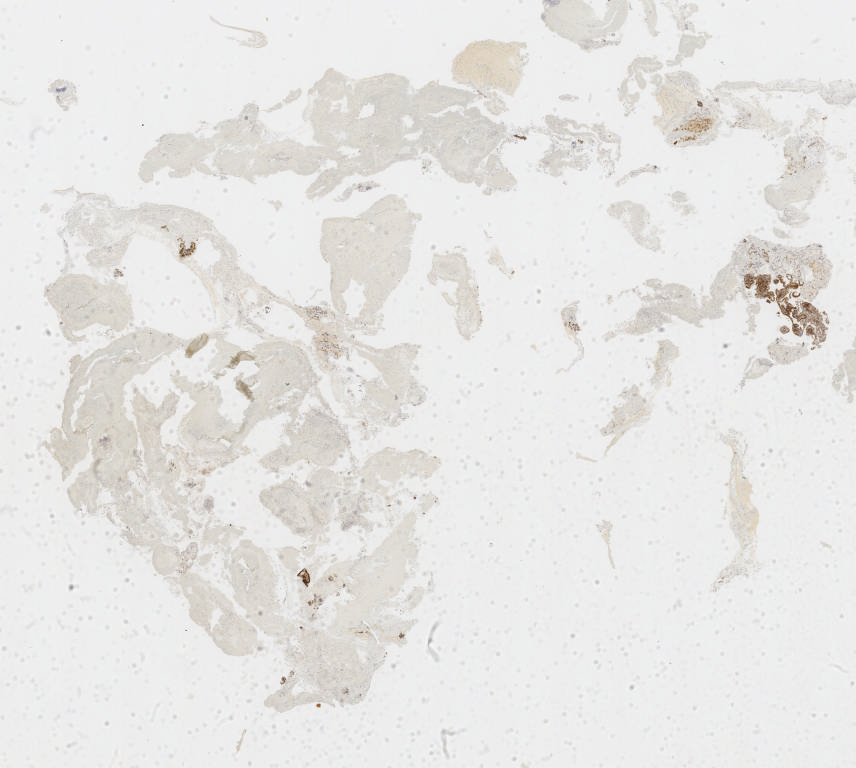

In [7]:
slide.associated_images['thumbnail']

Конкретный участок слайда можно посмотреть с помощью функции read_region((top_left_x, top_left_y), dimension, (width, height)), которая выдаёт изображение в формате PIL

In [27]:
print(slide.level_dimensions)

((27888, 25007), (6972, 6251), (1743, 1562))


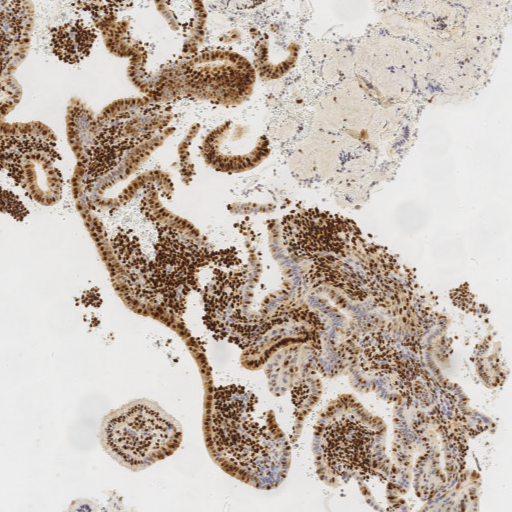

In [27]:
slide.read_region((25000, 9000), 1, (512, 512))

Выделение эпителия:

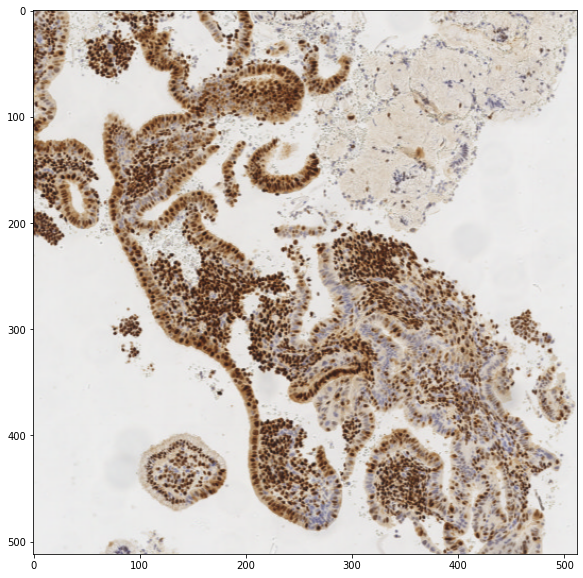

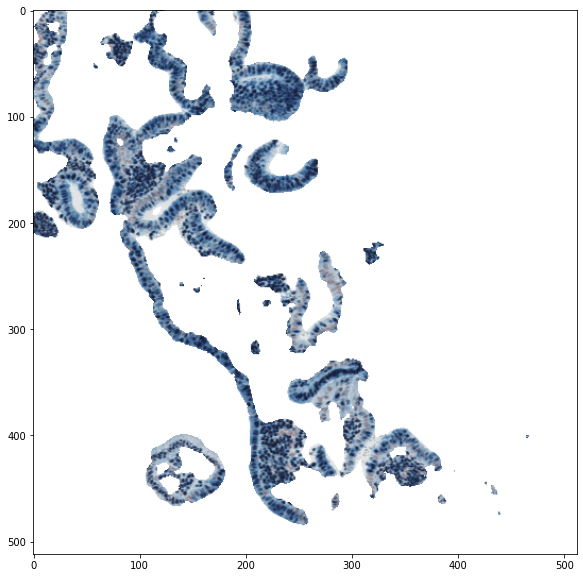

In [25]:
void(slide.get_masked_region((25000, 9000), 1, (512, 512), show=True))

Окрасившиеся и неокрасившиеся ядра

Вырезаем участок слайда, создаём объект класса PieceOfSlide

Класс позволяет разными способами находить окрашенные и неокрашенные ядра, выделять эпителий на фрагменте.

Наиболее точно на данный момент работают функции visualize_*

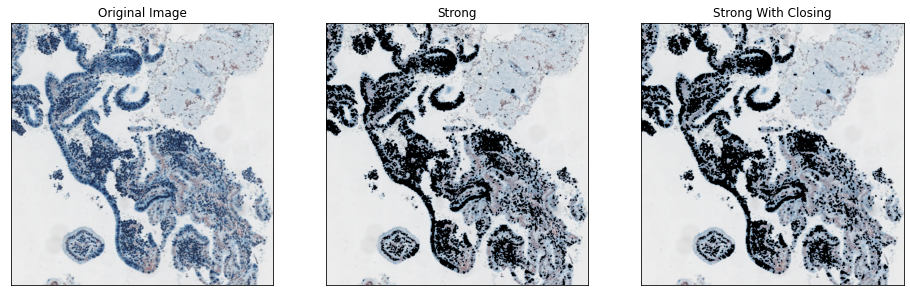

(array([  0,   0,   0, ..., 511, 511, 511]), array([ 51, 148, 217, ..., 438, 446, 451]))


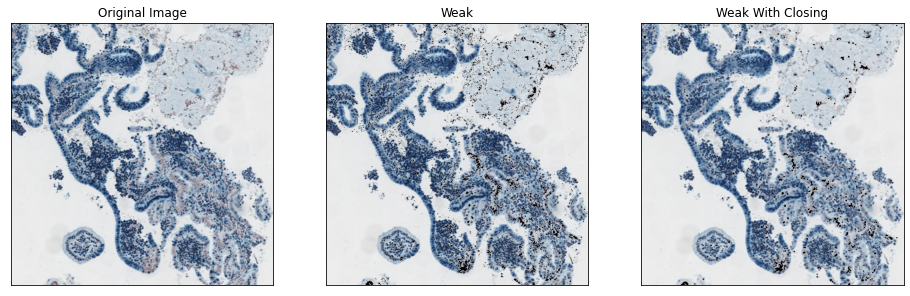

In [34]:
region = POS.PieceOfSlide(slide.read_region((25000, 9000), 1, (512, 512)))
s = region.visualize_strong() # коричневые
w = region.visualize_weak()   # синие
s, w = s[0], w[0]

Приблизительная величина Histoscore для этой картинки:

In [35]:
print('Brown:', s)
print('Blue: ', w)
print('H:    ', (s + 2 * w)/(s + w))
# H = (0 * None + 1 * Weak + 2 * Medium + 3 * Strong) / (None + Medium + Weak + Strong)
# На данный момент не умеем классифицировать ядра коричневых оттенков, поэтому учитываем просто все коричневые ядра с коэффициентом 2

Brown: 127047
Blue:  7878
H:     1.0583879933296276
